In [212]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pingouin import welch_anova, pairwise_tukey

### Resumo

O desafio proposto trata sobre o transtorno depressivo, um problema multifatorial que pode ter várias possíveis combinações de situações como causa. <br>
Os dados disponíveis são resultados da NHNES (National Health and Nutrition Examination Survey), realizada anualmente nos EUA para avaliar a saúde e nutrição de adultos e crianças. <br>
Seu desafio é responder as seguintes perguntas:
 
- Qual o perfil de indivíduos (adultos maiores de 18 anos) com sintomas depressivos nos EUA no período de 2005-2006?
- Hábitos saudáveis de alimentação e atividade física estão associados a menores índices de depressão nesta população?


#### **Cleaning**

In [95]:

df = pd.merge(
    pd.read_csv('../../data/09. TCC/depressão/DEMO_PHQ.csv'),
    pd.read_csv('../../data/09. TCC/depressão/PAG_HEI.csv'),
    on='SEQN', how='outer'
    ).drop_duplicates()

# pessoas que responderam não saber ou não quis responder terão sua resposta trocada pela mediana
for col in [col for col in df.columns if 'DPQ' in col]:
    df.loc[(df[col] == 7) | (df[col] == 9), col] = df[col].median()
    df.loc[(df[col] == 7) | (df[col] == 9), col] = df.loc[(df[col] == 7) | (df[col] == 9), col].astype(int)

df['PHQ9'] = df[[col for col in df.columns if 'DPQ' in col]].sum(axis=1)
df['PHQ9_GROUP'] = df['PHQ9'].apply(lambda x: 'Sem sintomas' if x < 5 else 'Poucos sintomas' if x < 10 else 'Sintomas moderados a severos')

df = df[[
    # infos pessoais
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC', 
    # questões
    'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060',
    'DPQ070', 'DPQ080', 'DPQ090', 'PHQ9', 'PHQ9_GROUP', 
    ### questões "tradução": 
        # 0 = Nenhuma vez
        # 1 = Menos de uma semana
        # 2 = Uma semana ou mais
        # 3 = Quase todos os dias
        # 7 = Se recusou a responder
        # 9 = Não sabe
        # score = somatório
        # grupo = score < 5: sem sintomas; 5 <= score < 10: poucos sintomas; score >= 10: sintomas moderados a severos
    # Physical Activity Guideline (PAG)
    'PAG_MINW', 'ADHERENCE', 
    # alimentação
    'HEI2015C1_TOTALVEG', 'HEI2015C2_GREEN_AND_BEAN', 'HEI2015C3_TOTALFRUIT',
    'HEI2015C4_WHOLEFRUIT', 'HEI2015C5_WHOLEGRAIN', 'HEI2015C6_TOTALDAIRY',
    'HEI2015C7_TOTPROT', 'HEI2015C8_SEAPLANT_PROT', 'HEI2015C9_FATTYACID',
    'HEI2015C10_SODIUM', 'HEI2015C11_REFINEDGRAIN', 'HEI2015C12_SFAT',
    'HEI2015C13_ADDSUG', 'HEI2015_TOTAL_SCORE'
    ### alimentação "tradução": 
        # quanto maior, maior o consumo
        # score = somatório
    ]]

# analise sobre pessoas adultas (idade >= 18 anos) e pessoas que tenham respondido a pesquisa
df = df[(df['RIDAGEYR'] >= 18) & (df['DPQ010'].notna())].copy()

# fillna com o valor mediano 
df['INDFMINC'] = df['INDFMINC'].fillna(df['INDFMINC'].median())
df[[col for col in df.columns if 'HEI2015' in col]] = df[[col for col in df.columns if 'HEI2015' in col]].fillna(df[[col for col in df.columns if 'HEI2015' in col]].median())
df['HEI2015_TOTAL_SCORE'] = df[[col for col in df.columns if 'HEI2015' in col and 'SCORE' not in col]].sum(axis=1)

# "tradução" dos dados, não traduzir caso modelar regressão linear
df['RIAGENDR'] = df['RIAGENDR'].replace({2: 'Feminino', 1: 'Masculino'})
df['RIDRETH1'] = df['RIDRETH1'].replace({1: 'Branco não hispânico', 2: 'Negro não hispânico', 3: 'Mexicano americano', 4: 'Outro', 5: 'Outro hispânico'})
df['DMDEDUC'] = df['DMDEDUC'].replace({1: 'Menor que 9o ano', 2: '9-12o ano', 3: 'Ensino médio', 4: 'Ensino superior incompleto', 5: 'Superior completo ou maior', 7: 'Se recusou a responder', 9: 'Não sabe'})
df['INDFMINC'] = df['INDFMINC'].replace({1: '0-4999', 2: '5000-9999', 3: '10000-14999', 4: '15000-19999', 5: '20000-24999', 6: '25000-34999', 7: '35000-44999', 8: '45000-54999', 9: '55000-64999', 10: '65000-74999', 
                                         11: 'Maior ou igual a 75000', 12: 'Maior que 20000', 13: 'Menor que 20000', 77: 'Se recusou a responder', 99: 'Não sabe'})
df['ADHERENCE'] = df['ADHERENCE'].replace({1: 'Baixo (< 150 min/semana)', 2: 'Adequado (150-300 min/semana)', 3: 'Acima (> 300 min/semana)'})

#### **EDA**

In [96]:

print(df.shape)
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(4836, 33)


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
SEQN,int64,0,0.0,4836,"[31131, 31132, 31134]"
RIAGENDR,object,0,0.0,2,"[Feminino, Masculino]"
RIDAGEYR,float64,0,0.0,68,"[44.0, 70.0, 73.0]"
RIDRETH1,object,0,0.0,5,"[Outro, Mexicano americano, Negro não hispânico]"
DMDEDUC,object,0,0.0,6,"[Ensino superior incompleto, Superior completo..."
INDFMINC,object,0,0.0,15,"[Maior ou igual a 75000, Maior que 20000, 1000..."
DPQ010,float64,0,0.0,4,"[0.0, 1.0, 2.0]"
DPQ020,float64,0,0.0,4,"[0.0, 1.0, 2.0]"
DPQ030,float64,0,0.0,4,"[0.0, 1.0, 3.0]"
DPQ040,float64,0,0.0,4,"[0.0, 1.0, 2.0]"


##### **analise univariada**

Informações pessoais

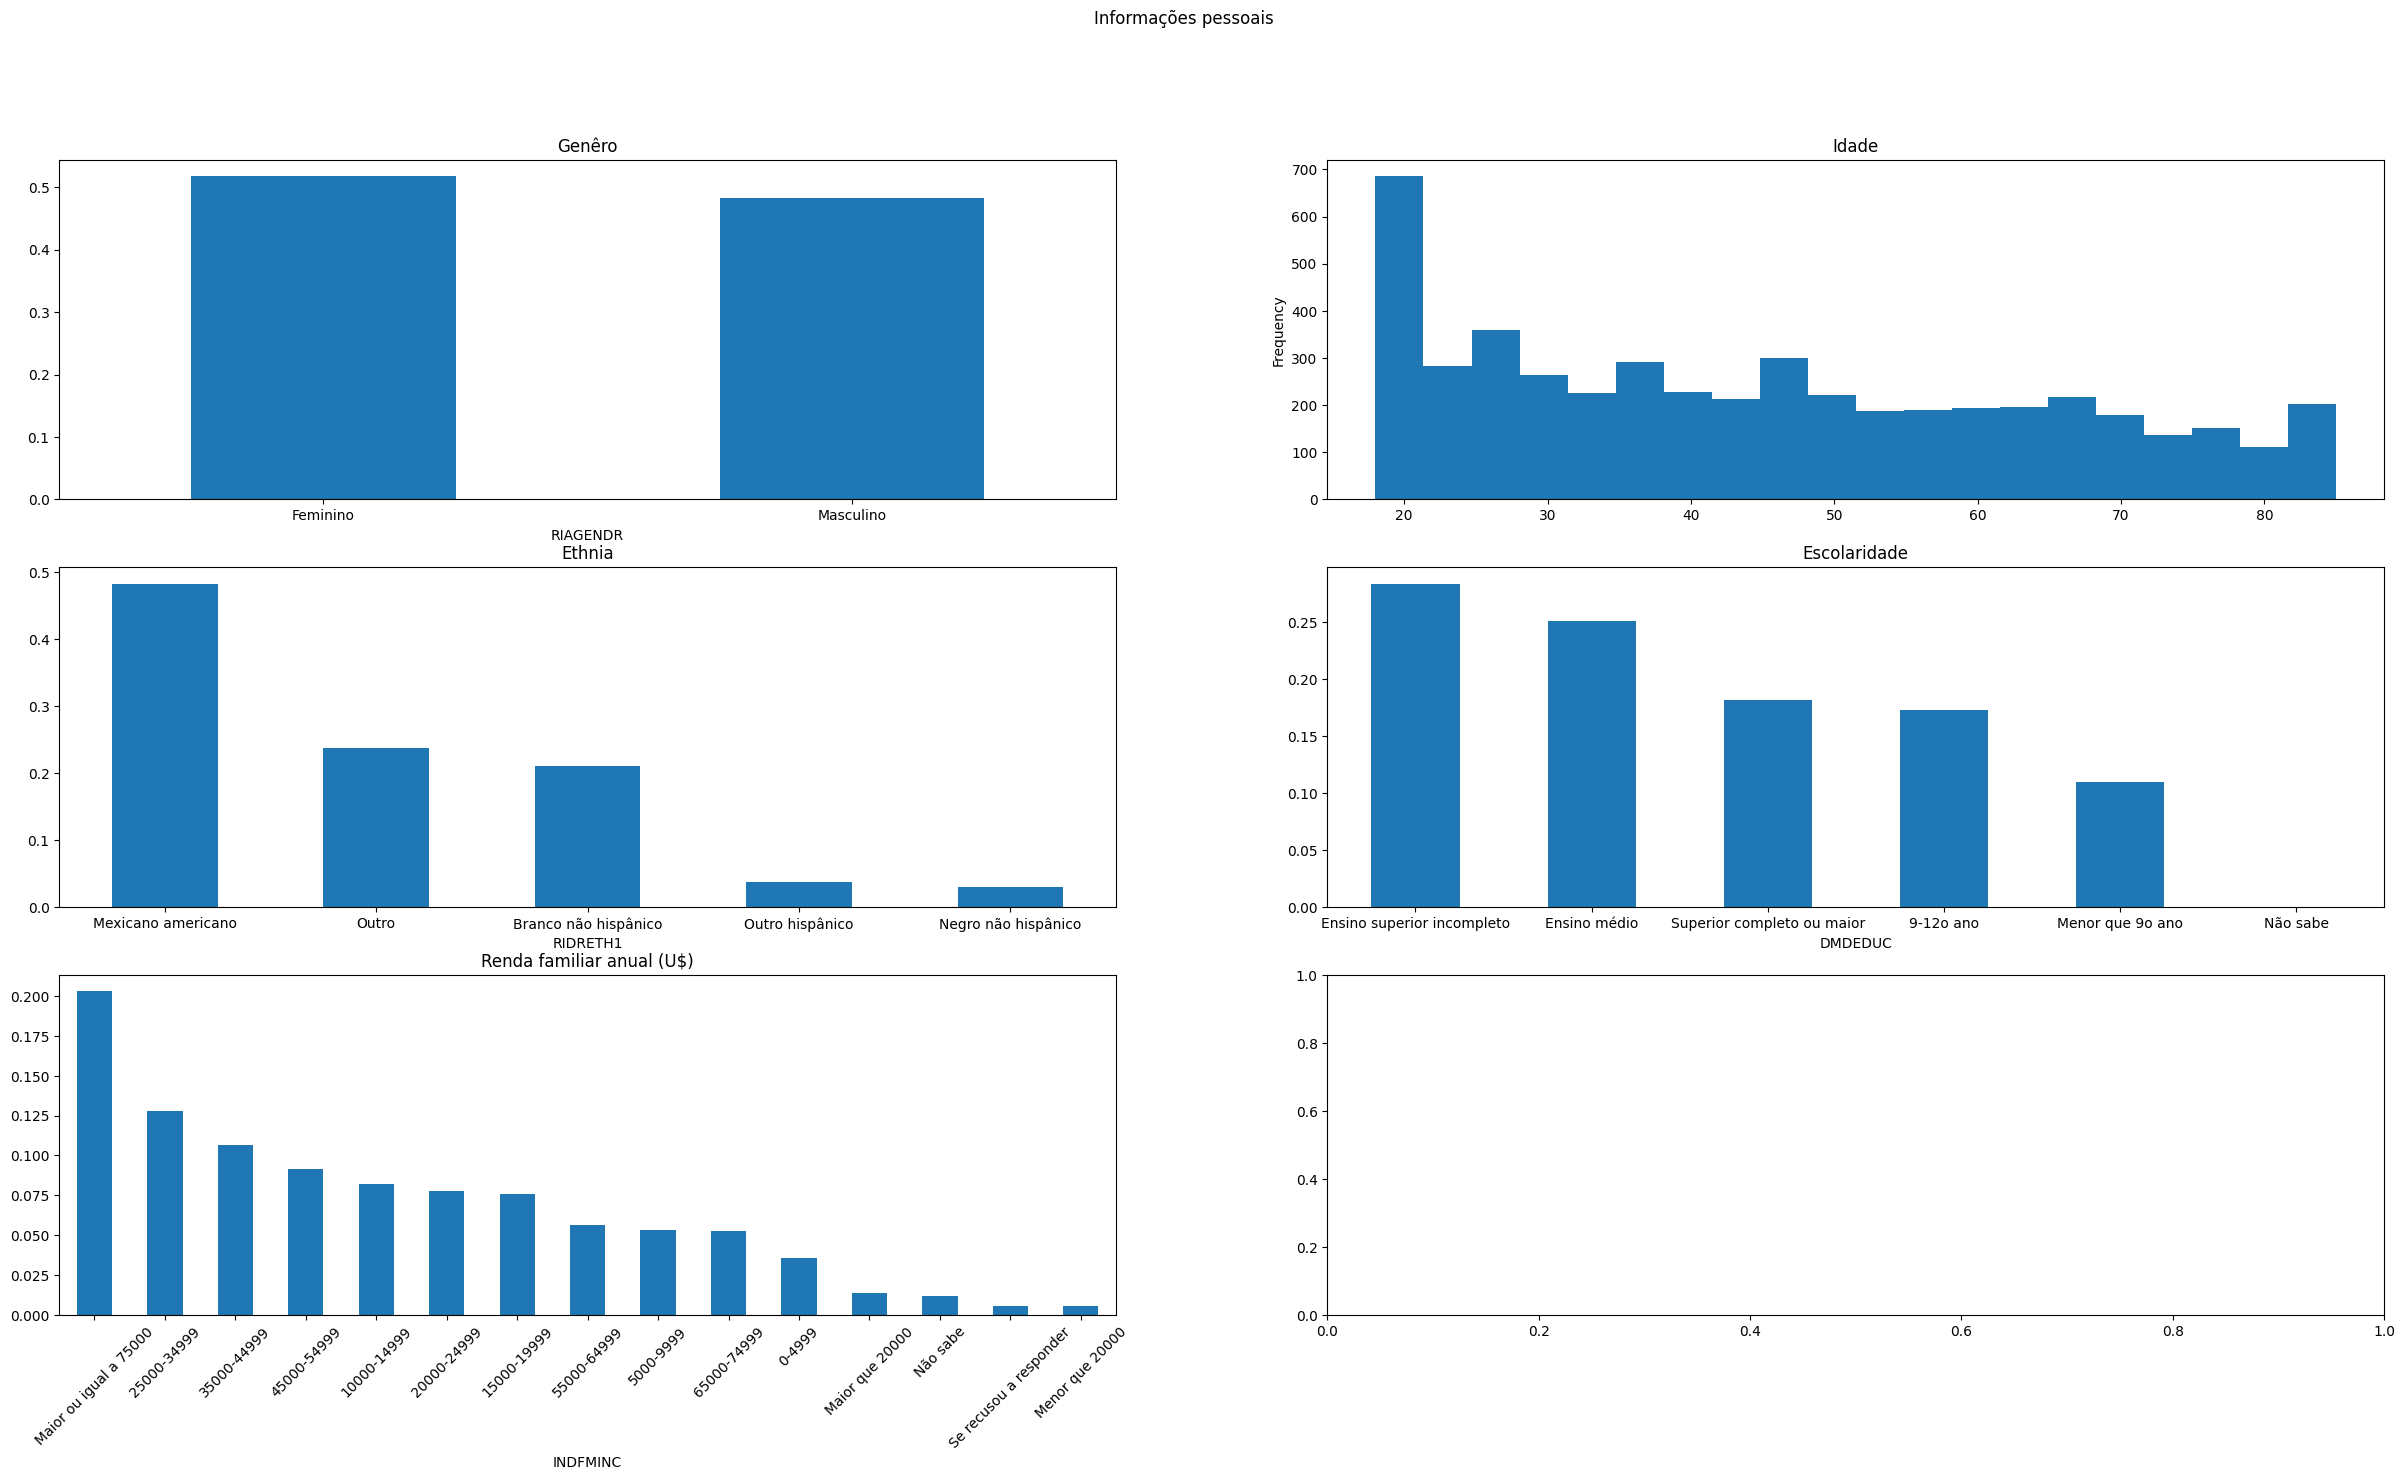

In [86]:

fig, axs = plt.subplots(3, 2, figsize=(30, 15))

df['RIAGENDR'].value_counts(normalize=True).plot.bar(ax=axs[0][0])
axs[0][0].set_title('Genêro')
axs[0][0].tick_params(axis='x', labelrotation=0)

df['RIDAGEYR'].plot.hist(ax=axs[0][1], bins=20)
axs[0][1].set_title('Idade')
axs[0][1].tick_params(axis='x', labelrotation=0)

df['RIDRETH1'].value_counts(normalize=True).plot.bar(ax=axs[1][0])
axs[1][0].set_title('Ethnia')
axs[1][0].tick_params(axis='x', labelrotation=0)

df['DMDEDUC'].value_counts(normalize=True).plot.bar(ax=axs[1][1])
axs[1][1].set_title('Escolaridade')
axs[1][1].tick_params(axis='x', labelrotation=0)

df['INDFMINC'].value_counts(normalize=True).plot.bar(ax=axs[2][0])
axs[2][0].set_title('Renda familiar anual (U$)')
axs[2][0].tick_params(axis='x', labelrotation=45)

plt.suptitle('Informações pessoais')
# plt.tight_layout()
plt.show()

*insights*:
- dataset balanceado entre homens e mulheres.
- pico de pessoas com 20 anos, e quantidade balanceada de pessoas até 90 anos.
- praticamente 50% do dataset é mexicano(a) americano(a).
- escolaridade levemente balanceada.
- grande parte das pessoas possuem renda familiar U$ 75k+ (20%).

Exercicio aeróbico

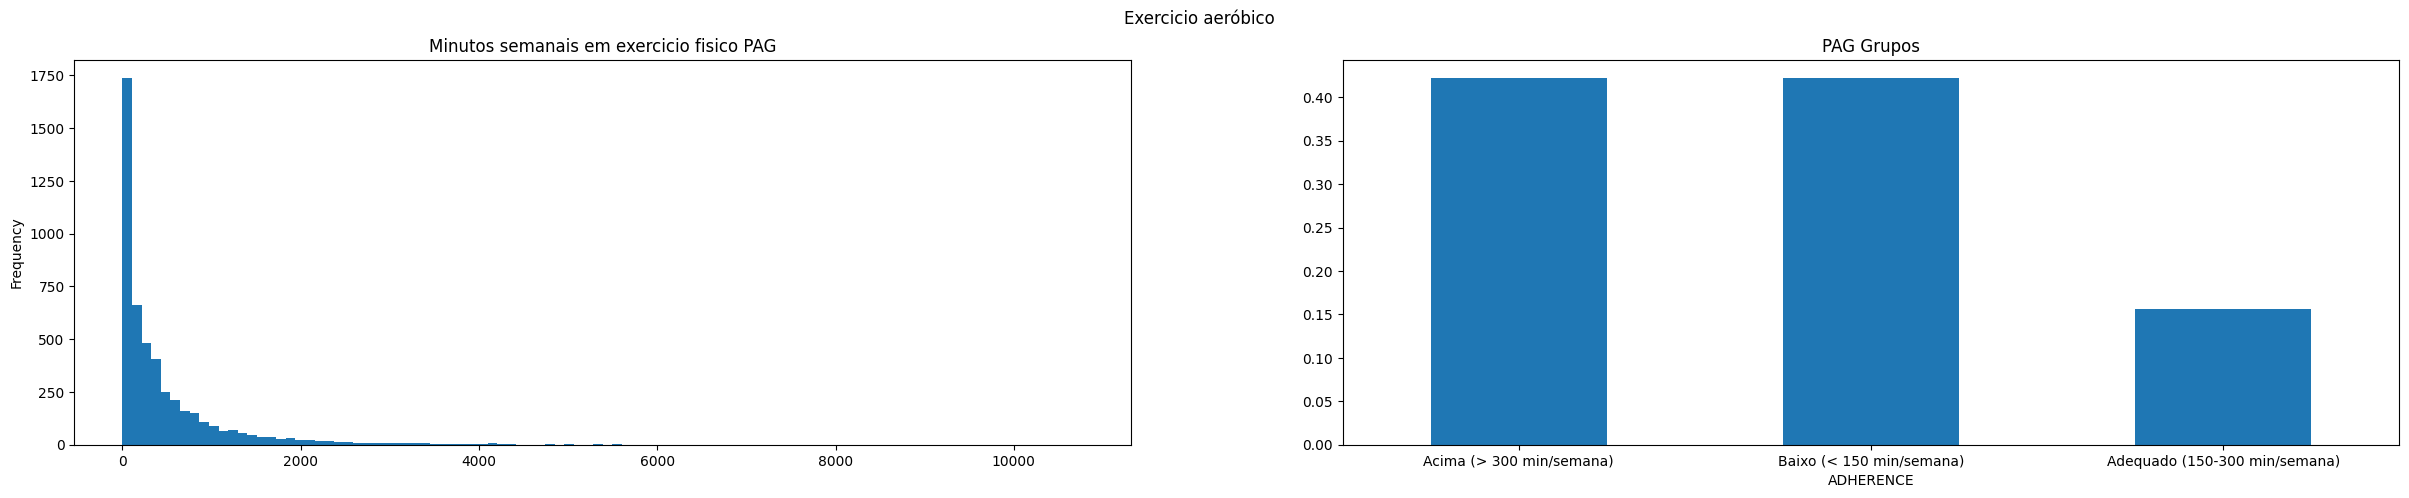

In [97]:

fig, axs = plt.subplots(1, 2, figsize=(30, 5))

df['PAG_MINW'].plot.hist(ax=axs[0], bins=100)
axs[0].set_title('Minutos semanais em exercicio fisico PAG')

df['ADHERENCE'].value_counts(normalize=True).plot.bar(ax=axs[1])
axs[1].set_title('PAG Grupos')
axs[1].tick_params(axis='x', labelrotation=0)

plt.suptitle('Exercicio aeróbico')
plt.show()

*insights*:
- existe um pico de pessoas que não fazem exercicio.
- existe uma proporção alta de pessoas que fazem pouco exercicio semanalmente (pouco mais de 40%).
- maioria da pessoas fazem exercicio com frequencia forma adequada ou acima (pouco menos de 60%).

Alimentação

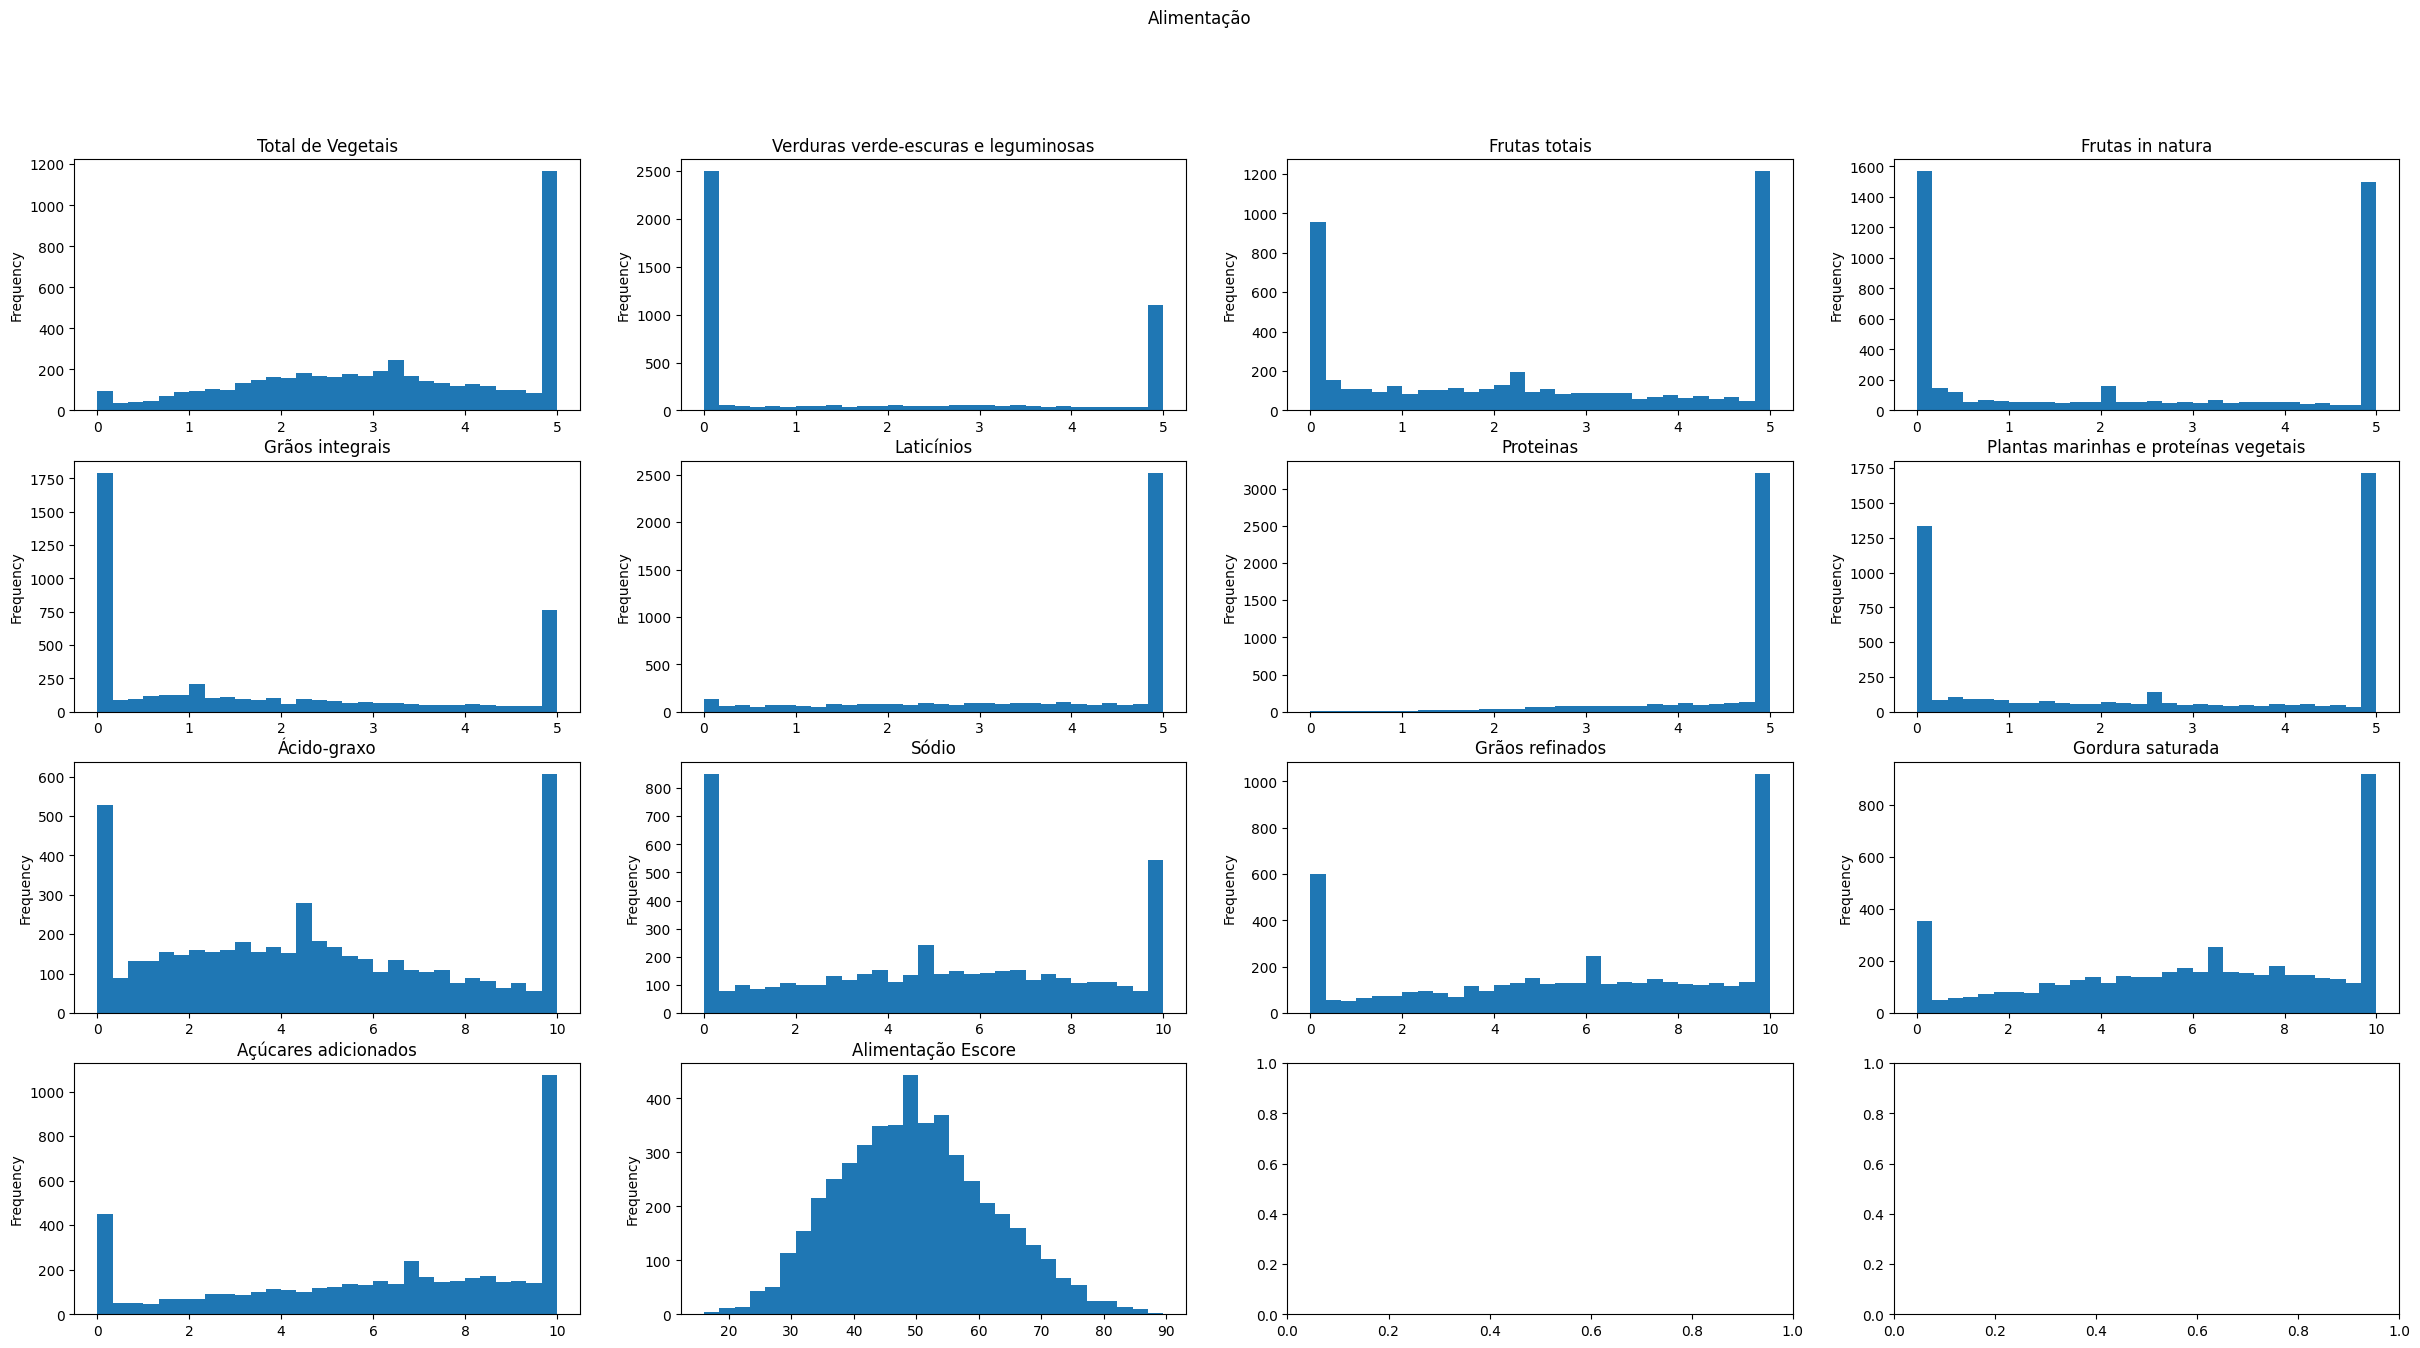

In [98]:

fig, axs = plt.subplots(4, 4, figsize=(30, 15))

df['HEI2015C1_TOTALVEG'].plot.hist(ax=axs[0][0], bins=30)
axs[0][0].set_title('Total de Vegetais')

df['HEI2015C2_GREEN_AND_BEAN'].plot.hist(ax=axs[0][1], bins=30)
axs[0][1].set_title('Verduras verde-escuras e leguminosas')

df['HEI2015C3_TOTALFRUIT'].plot.hist(ax=axs[0][2], bins=30)
axs[0][2].set_title('Frutas totais')

df['HEI2015C4_WHOLEFRUIT'].plot.hist(ax=axs[0][3], bins=30)
axs[0][3].set_title('Frutas in natura')

df['HEI2015C5_WHOLEGRAIN'].plot.hist(ax=axs[1][0], bins=30)
axs[1][0].set_title('Grãos integrais')

df['HEI2015C6_TOTALDAIRY'].plot.hist(ax=axs[1][1], bins=30)
axs[1][1].set_title('Laticínios')

df['HEI2015C7_TOTPROT'].plot.hist(ax=axs[1][2], bins=30)
axs[1][2].set_title('Proteinas')

df['HEI2015C8_SEAPLANT_PROT'].plot.hist(ax=axs[1][3], bins=30)
axs[1][3].set_title('Plantas marinhas e proteínas vegetais')

df['HEI2015C9_FATTYACID'].plot.hist(ax=axs[2][0], bins=30)
axs[2][0].set_title('Ácido-graxo')

df['HEI2015C10_SODIUM'].plot.hist(ax=axs[2][1], bins=30)
axs[2][1].set_title('Sódio')

df['HEI2015C11_REFINEDGRAIN'].plot.hist(ax=axs[2][2], bins=30)
axs[2][2].set_title('Grãos refinados')

df['HEI2015C12_SFAT'].plot.hist(ax=axs[2][3], bins=30)
axs[2][3].set_title('Gordura saturada')

df['HEI2015C13_ADDSUG'].plot.hist(ax=axs[3][0], bins=30)
axs[3][0].set_title('Açúcares adicionados')

df['HEI2015_TOTAL_SCORE'].plot.hist(ax=axs[3][1], bins=30)
axs[3][1].set_title('Alimentação Escore')

plt.suptitle('Alimentação')
plt.show()

*Insights:*
- existe um padrão de que alguem apenas não come ou come muito alguma coisa (famoso 8 ou 80), nos alimentos: verduras..., frutas, grãos integrais, plantas marinhas, acido-graxo, sódio, grãos refinados, gordura saturada (não tão "forte") e açúcares adicionados.
  porem em ácido-graxo, sódio e grãos refinados possuem algumas pessoas que consomem tal coisa moderadamente.
- laticinios, proteinas são alimentos normalmente muito consumido. i.e. normalmente não acontece de apenas um individuo comer pouco.

Perguntas relacionadas a depressão ~ o quão frequente, semanalmente, acontecem coisas que remetem a depressão

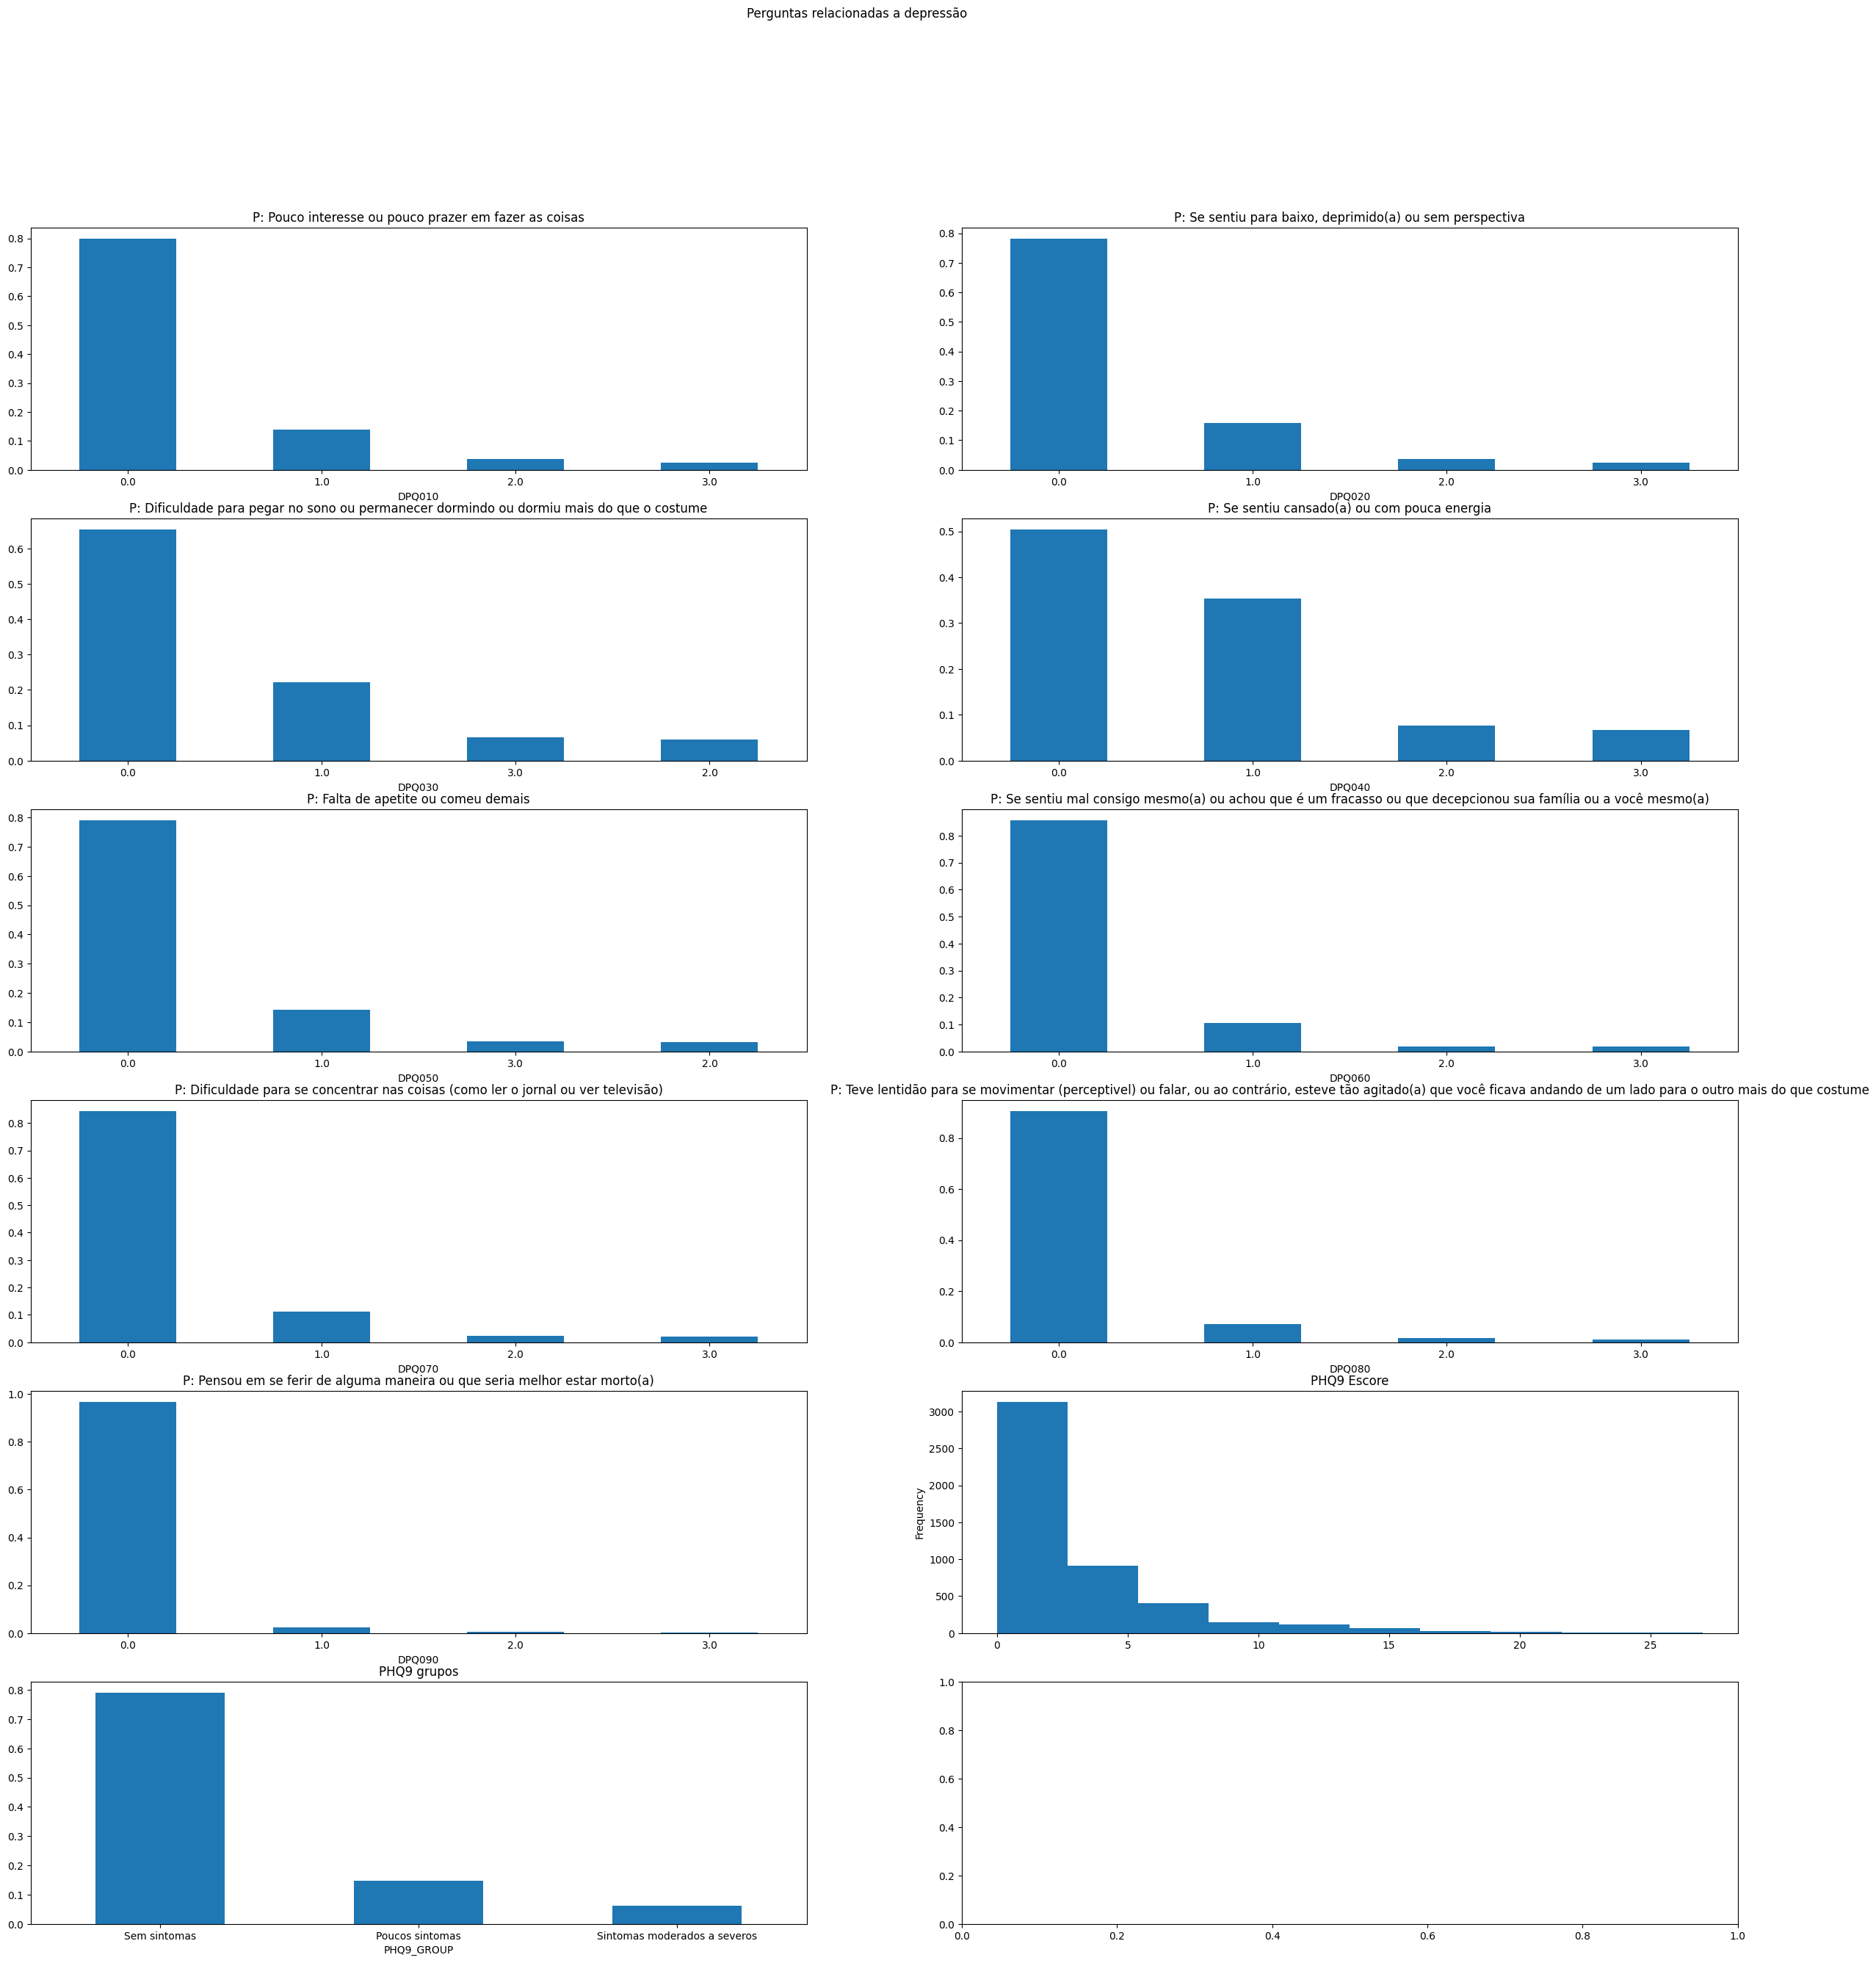

In [120]:

fig, axs = plt.subplots(6, 2, figsize=(30, 30))

df['DPQ010'].value_counts(normalize=True).plot.bar(ax=axs[0][0])
axs[0][0].set_title('P: Pouco interesse ou pouco prazer em fazer as coisas')
axs[0][0].tick_params(axis='x', labelrotation=0)

df['DPQ020'].value_counts(normalize=True).plot.bar(ax=axs[0][1])
axs[0][1].set_title('P: Se sentiu para baixo, deprimido(a) ou sem perspectiva')
axs[0][1].tick_params(axis='x', labelrotation=0)

df['DPQ030'].value_counts(normalize=True).plot.bar(ax=axs[1][0])
axs[1][0].set_title('P: Dificuldade para pegar no sono ou permanecer dormindo ou dormiu mais do que o costume')
axs[1][0].tick_params(axis='x', labelrotation=0)

df['DPQ040'].value_counts(normalize=True).plot.bar(ax=axs[1][1])
axs[1][1].set_title('P: Se sentiu cansado(a) ou com pouca energia')
axs[1][1].tick_params(axis='x', labelrotation=0)

df['DPQ050'].value_counts(normalize=True).plot.bar(ax=axs[2][0])
axs[2][0].set_title('P: Falta de apetite ou comeu demais')
axs[2][0].tick_params(axis='x', labelrotation=0)

df['DPQ060'].value_counts(normalize=True).plot.bar(ax=axs[2][1])
axs[2][1].set_title('P: Se sentiu mal consigo mesmo(a) ou achou que é um fracasso ou que decepcionou sua família ou a você mesmo(a)')
axs[2][1].tick_params(axis='x', labelrotation=0)

df['DPQ070'].value_counts(normalize=True).plot.bar(ax=axs[3][0])
axs[3][0].set_title('P: Dificuldade para se concentrar nas coisas (como ler o jornal ou ver televisão)')
axs[3][0].tick_params(axis='x', labelrotation=0)

df['DPQ080'].value_counts(normalize=True).plot.bar(ax=axs[3][1])
axs[3][1].set_title('P: Teve lentidão para se movimentar (perceptivel) ou falar, ou ao contrário, esteve tão agitado(a) que você ficava andando de um lado para o outro mais do que costume')
axs[3][1].tick_params(axis='x', labelrotation=0)

df['DPQ090'].value_counts(normalize=True).plot.bar(ax=axs[4][0])
axs[4][0].set_title('P: Pensou em se ferir de alguma maneira ou que seria melhor estar morto(a)')
axs[4][0].tick_params(axis='x', labelrotation=0)

df['PHQ9'].plot.hist(ax=axs[4][1])
axs[4][1].set_title('PHQ9 Escore')
axs[4][1].tick_params(axis='x', labelrotation=0)

df['PHQ9_GROUP'].value_counts(normalize=True).plot.bar(ax=axs[5][0])
axs[5][0].set_title('PHQ9 grupos')
axs[5][0].tick_params(axis='x', labelrotation=0)

plt.suptitle('Perguntas relacionadas a depressão')
plt.show()

*insights:*
- no geral existe poucas pessoas que individualmente possuem habitos depressivos.
- menos que 10% das pessoas possuem grandes sintomas de depressão.

##### **analise bivariada** - versus PHQ9 Escore

Informações pessoais

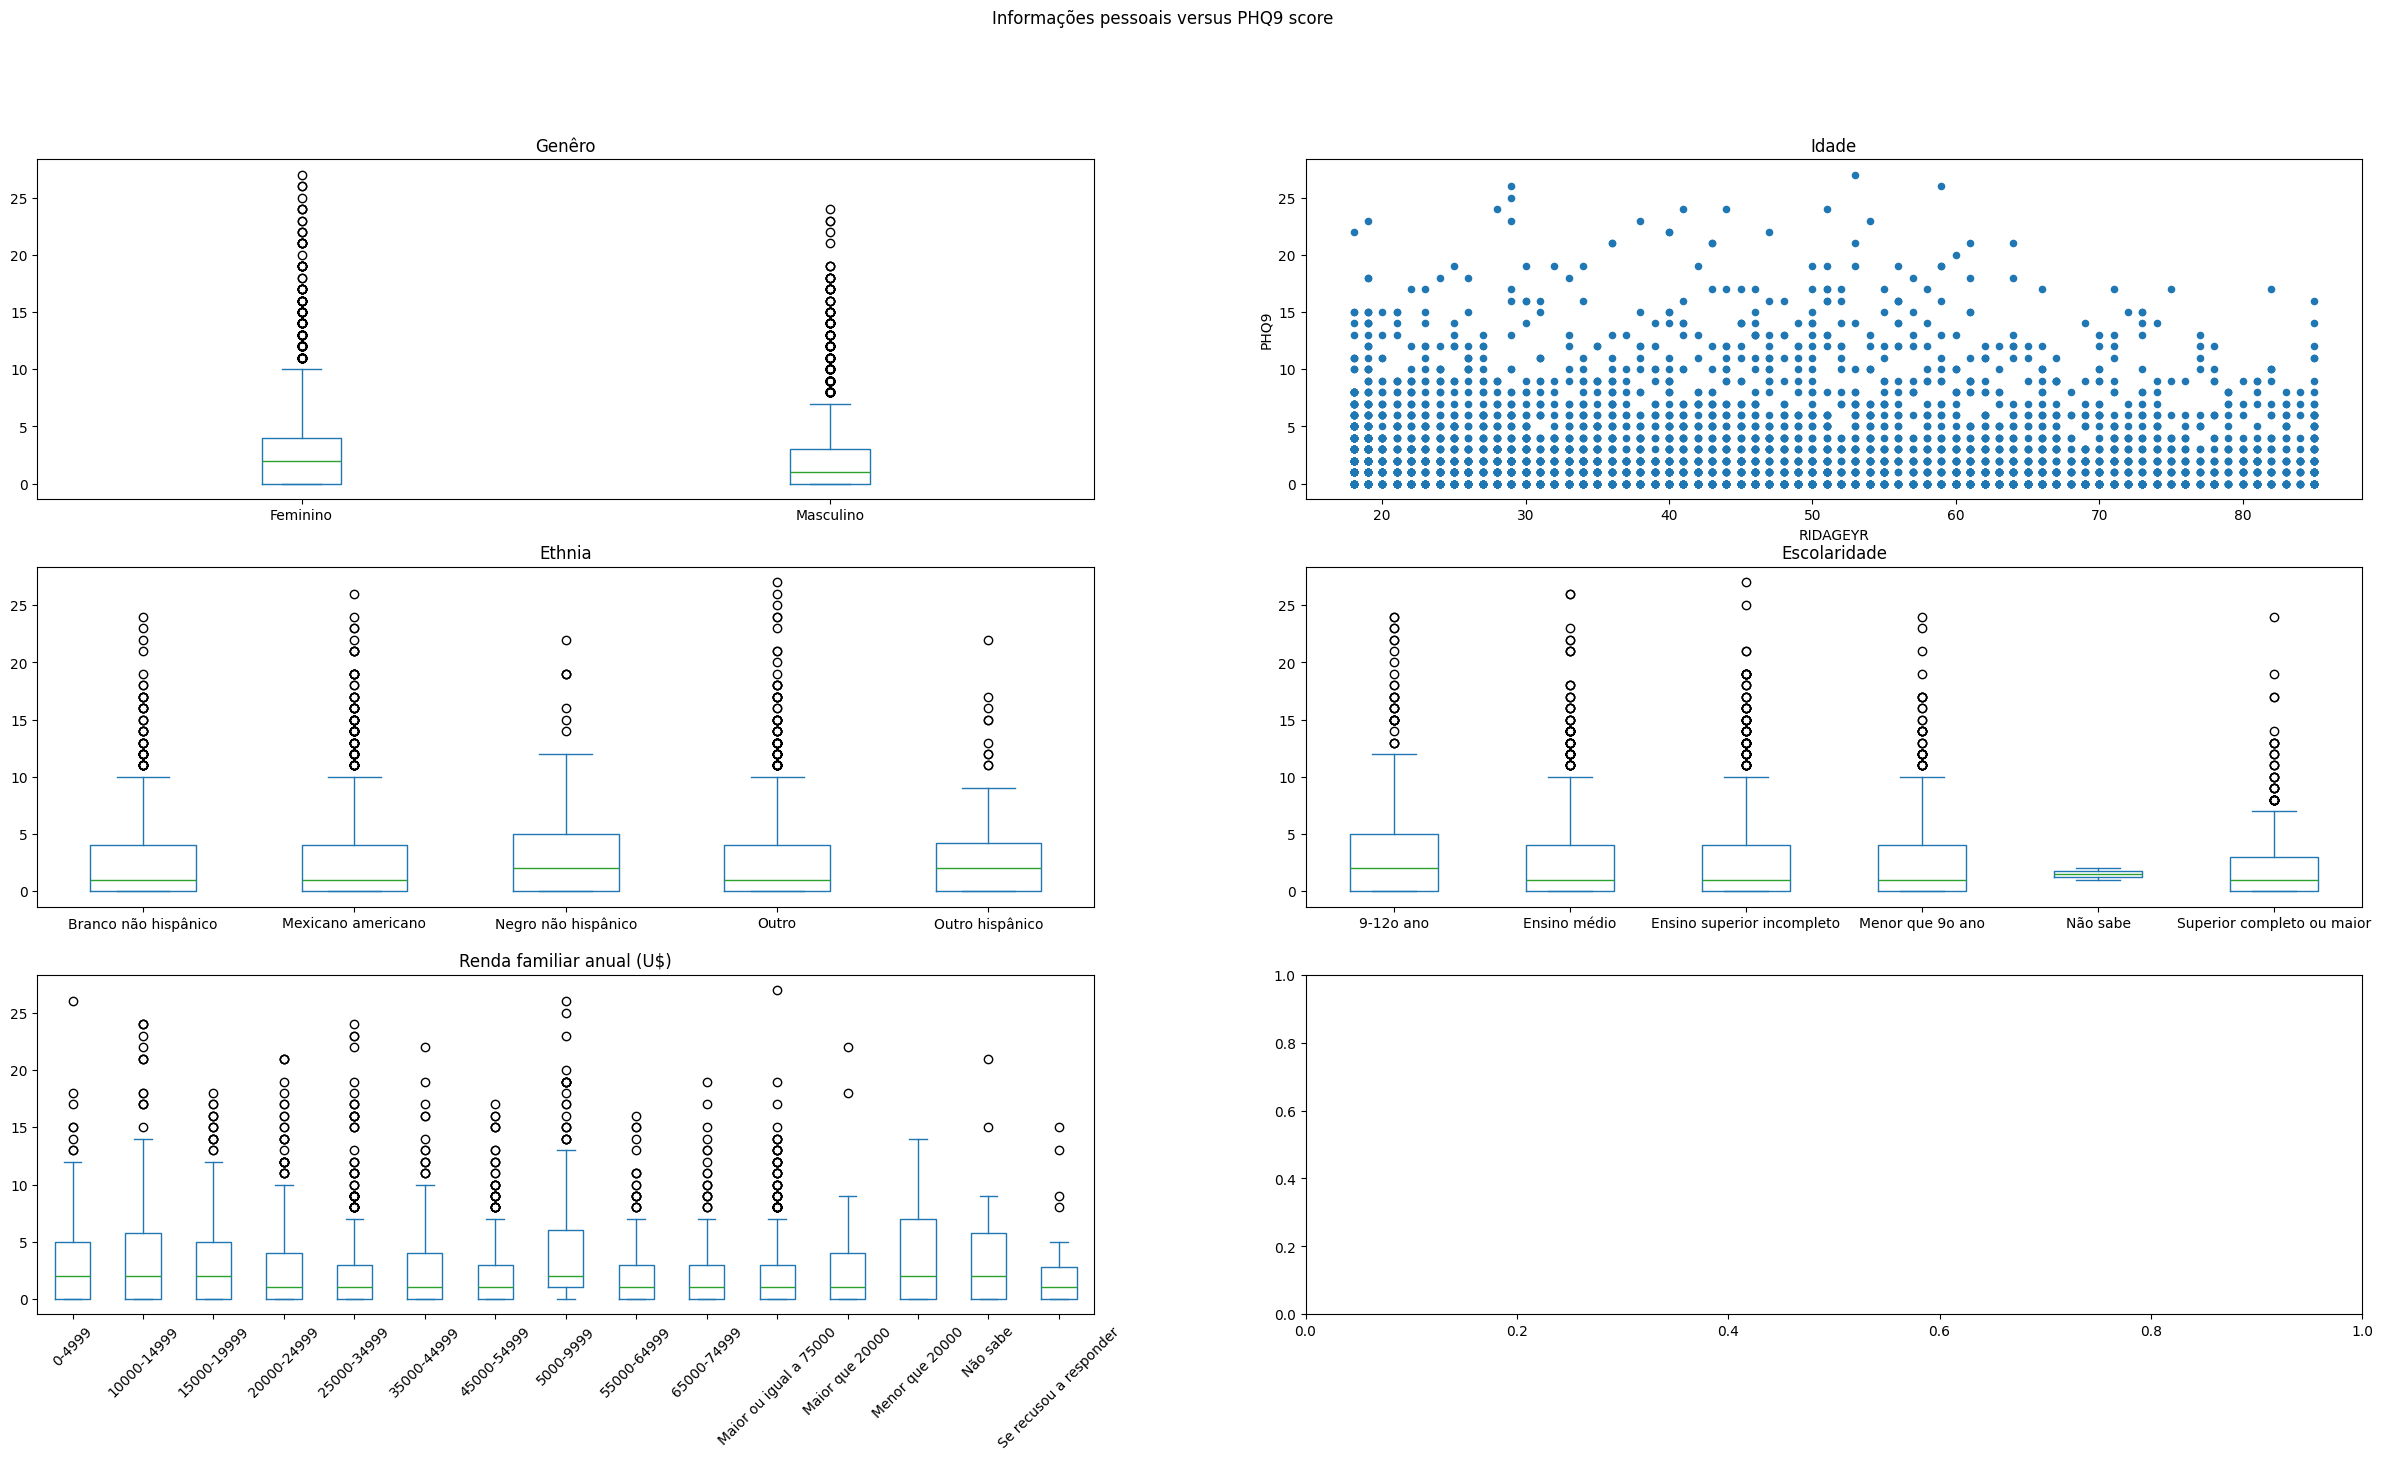

In [161]:

fig, axs = plt.subplots(3, 2, figsize=(30, 15))

df[['RIAGENDR', 'PHQ9']].plot.box(by='RIAGENDR', ax=axs[0][0])
axs[0][0].set_title('Genêro')

df[['RIDAGEYR', 'PHQ9']].plot.scatter(x='RIDAGEYR', y='PHQ9', ax=axs[0][1])
axs[0][1].set_title('Idade')

df[['RIDRETH1', 'PHQ9']].plot.box(by='RIDRETH1', ax=axs[1][0])
axs[1][0].set_title('Ethnia')

df[['DMDEDUC', 'PHQ9']].plot.box(by='DMDEDUC', ax=axs[1][1])
axs[1][1].set_title('Escolaridade')

df[['INDFMINC', 'PHQ9']].plot.box(by='INDFMINC', ax=axs[2][0])
axs[2][0].set_title('Renda familiar anual (U$)')
axs[2][0].tick_params(axis='x', labelrotation=45)

plt.suptitle('Informações pessoais versus PHQ9 score')
plt.show()

In [222]:

a = .05

print('-- Gênero')
display(df[['RIAGENDR', 'PHQ9']].groupby('RIAGENDR')['PHQ9'].mean().sort_values().reset_index(name='MEAN'))

# teste de hipoteses para 2 médias com var populacional desconhecidas e suspostamente diferentes. T-Student Welch
t_stat, p_value = ttest_ind( # h0: m1 = m2 (estatisticamente)
    df[df['RIAGENDR']=='Masculino']['PHQ9'].values, 
    df[df['RIAGENDR']=='Feminino']['PHQ9'].values, 
    equal_var=False) 
print('->', '' if p_value <= a else 'não', f'existe diferença estatistica entre as médias a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

print()
print('-- Idade')
print('-> correlação de pearson sobre Idade X PHQ9 Escore:',  df[['RIDAGEYR', 'PHQ9']].corr().values[0, 1])

print()
print('-- Ethnia')
display(df[['RIDRETH1', 'PHQ9']].groupby('RIDRETH1')['PHQ9'].mean().sort_values().reset_index(name='MEAN'))

# teste de hipoteses para 3+ médias com var populacional desconhecidas e suspostamente diferentes. ANOVA Welch
p_value = welch_anova(dv='PHQ9', between='RIDRETH1', data=df).values[0, 4] # h0: medias iguais (estatisticamente)
print('->', '' if p_value <= a else 'não', f'existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

print()
print('-- Educação')
display(df[['DMDEDUC', 'PHQ9']].groupby('DMDEDUC')['PHQ9'].mean().sort_values().reset_index(name='MEAN'))

# teste de hipoteses para 3+ médias com var populacional desconhecidas e suspostamente diferentes. ANOVA Welch
p_value = welch_anova(dv='PHQ9', between='DMDEDUC', data=df).values[0, 4] # h0: medias iguais (estatisticamente)
print('->', '' if p_value <= a else 'não', f'existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

# ... já que existe pelo menos 1 média diferente a outras, teste de hipoteses POST-HOC ~ pair wise Tukey entre as médias.
df_pairwise = pairwise_tukey(dv='PHQ9', between='DMDEDUC', data=df)
print('-> médias estatisticamente diferentes:')
display(df_pairwise[df_pairwise['p-tukey'] <= a])

print()
print('-- Renda familiar anual (U$)')
display(df[['INDFMINC', 'PHQ9']].groupby('INDFMINC')['PHQ9'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 3+ médias com var populacional desconhecidas e suspostamente diferentes. ANOVA Welch
p_value = welch_anova(dv='PHQ9', between='INDFMINC', data=df).values[0, 4] # h0: medias iguais (estatisticamente)
print('->', '' if p_value <= a else 'não', f'existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

# ... já que existe pelo menos 1 média diferente a outras, teste de hipoteses POST-HOC ~ pair wise Tukey entre as médias.
df_pairwise = pairwise_tukey(dv='PHQ9', between='INDFMINC', data=df)
print('-> médias estatisticamente diferentes:')
display(df_pairwise[df_pairwise['p-tukey'] <= a])

del(df_pairwise)

-- Gênero


,RIAGENDR,MEAN
0,Masculino,2.321321
1,Feminino,3.158483


->  existe diferença estatistica entre as médias a um intervalo de confiança de 0.95. p-value = 5.643941743327075e-15

-- Idade
-> correlação de pearson sobre Idade X PHQ9 Escore: -0.03639691654125304

-- Ethnia


,RIDRETH1,MEAN
0,Mexicano americano,2.616438
1,Branco não hispânico,2.772994
2,Outro hispânico,2.896739
3,Outro,2.912021
4,Negro não hispânico,3.431507


-> não existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de 0.95. p-value = 0.06192452464064889

-- Educação


,DMDEDUC,MEAN
0,Não sabe,1.500000
1,Superior completo ou maior,2.023891
2,Ensino superior incompleto,2.765477
3,Ensino médio,2.836214
4,Menor que 9o ano,3.090566
5,9-12o ano,3.178017


->  existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de 0.95. p-value = 0.0002198985856839822
-> médias estatisticamente diferentes:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
4,9-12o ano,Superior completo ou maior,3.178017,2.023891,1.154126,0.180446,6.395951,2.614775e-09,0.333322
8,Ensino médio,Superior completo ou maior,2.836214,2.023891,0.812323,0.165445,4.909943,1.392666e-05,0.238698
11,Ensino superior incompleto,Superior completo ou maior,2.765477,2.023891,0.741586,0.161399,4.594736,6.512529e-05,0.216667
13,Menor que 9o ano,Superior completo ou maior,3.090566,2.023891,1.066675,0.205480,5.191137,3.237348e-06,0.322475



-- Renda familiar anual (U$)


,INDFMINC,MEAN
0,Maior ou igual a 75000,2.058045
1,55000-64999,2.235294
2,45000-54999,2.320542
3,65000-74999,2.472441
4,35000-44999,2.489320
5,25000-34999,2.553226
6,Se recusou a responder,2.571429
7,Maior que 20000,2.701493
8,20000-24999,3.122667
9,Não sabe,3.293103


->  existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de 0.95. p-value = 2.3063535328216177e-17
-> médias estatisticamente diferentes:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
9,0-4999,Maior ou igual a 75000,3.327485,2.058045,1.269441,0.306694,4.139111,3.245905e-03,0.409152
16,10000-14999,25000-34999,3.859296,2.553226,1.306071,0.237728,5.493963,4.277710e-06,0.312884
17,10000-14999,35000-44999,3.859296,2.489320,1.369976,0.247021,5.545980,3.191837e-06,0.345561
18,10000-14999,45000-54999,3.859296,2.320542,1.538755,0.255622,6.019638,1.961613e-07,0.384365
20,10000-14999,55000-64999,3.859296,2.235294,1.624002,0.291176,5.577387,2.671099e-06,0.388589
21,10000-14999,65000-74999,3.859296,2.472441,1.386856,0.297242,4.665749,3.120356e-04,0.324415
22,10000-14999,Maior ou igual a 75000,3.859296,2.058045,1.801252,0.219931,8.190071,6.034062e-13,0.509744
28,15000-19999,25000-34999,3.421196,2.553226,0.867970,0.243558,3.563703,2.856959e-02,0.225491
29,15000-19999,35000-44999,3.421196,2.489320,0.931875,0.252637,3.688591,1.848621e-02,0.261085
30,15000-19999,45000-54999,3.421196,2.320542,1.100654,0.261053,4.216205,2.350318e-03,0.307699


*insights:*
- para genêro existe diferença estatistica entre as médias, onde média "Feminino" > média "Masculino".
- para idade a correlação com PHQ9 é praticamente zero.
- para ethnia não existe diferença estatistica.
- para educação existe diferença estatistica entre a média "Superior completo ou maior" com as outras ("Menor que 9o ano", "9-12o ano", "Ensino médio", "Ensino superior incompleto") onde média "Superior completo ou maior" > média outras.
- para renda familiar anual existe diferença estatistica entre as médias ... (gigante output / é o ultimo dataframe acima) onde resumidamente quanto menor a renda -> maior a média PHQ9

***... com 95% de confiança.***

Exercicio aeróbico

Alimentação